# FixMatch


In [17]:
# deep learning
import torch
import torch.nn as nn
from torch.distributions.transforms import LowerCholeskyTransform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# vizualisation
import torchsummary

# transforms
import torchvision.transforms as T
import kornia.augmentation as K
from torchvision.transforms.v2 import RandAugment

# metrics
from torchmetrics import Accuracy

# torchvision
import torchvision
import torchvision.transforms as transforms

# plotting
import matplotlib.pyplot as plt
from torchview import draw_graph

from IPython.display import display
from IPython.core.display import SVG, HTML

from tqdm import tqdm

# typing
from typing import Callable

from utils import Data, DataFixMatch, plot_images, plot_transform
from model import ConvNN, display_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Set device
if (int(torch.__version__.split(".")[0]) >= 2) or (int(torch.__version__.split(".")[1]) >= 13) and torch.has_mps:
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

mps


In [3]:
IMG_SHAPE = (3, 32, 32)
# See Table 4
TAU = 0.95
LAMBDA_U = 1
MU = 7
BATCH_SIZE = 64 # B
LR = 0.03
BETA = 0.9
WEIGHT_DECAY = 0.001

In [15]:
dataset = Data(batch_size=BATCH_SIZE)

trainLoader = dataset.get_train_loader()
validLoader = dataset.get_valid_loader()
testLoader = dataset.get_test_loader()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
display_model(model=ConvNN(), batch_size=BATCH_SIZE, img_shape=IMG_SHAPE) 

In [6]:
EPOCHS = 2

model = ConvNN()
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=BETA)
criterion = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    for (images, labels) in (pbar := tqdm(trainLoader, desc=f"Epoch {epoch: >5}")) :
        # extract mini batch
        images, labels = images.to(device), labels.to(device)
        # forward pass
        outputs = model.forward(images)
        label_pred = outputs.argmax(dim=1)
        loss = criterion.forward(outputs, labels)
        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()
        
        # update metrics
        epoch_loss += loss.item()*images.size(0)/len(trainLoader)
        # print statistics
        pbar.set_postfix(
            {
                "train_loss": f"{loss.item():.2f}",
                "epoch_loss": f"{epoch_loss:.2f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.3f}",
            }
        )
    # scheduler.step()

    # Validation
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for (images_val, label_val) in (pbar := tqdm(validLoader, desc=f"Epoch val {epoch: >1}")):
            images_val, label_val = images_val.to(device), label_val.to(device)
            outputs_val = model.forward(images_val)
            label_pred_val = outputs_val.argmax(dim=1)
            loss_val = criterion.forward(outputs_val, label_val)
            val_epoch_loss += loss_val.item()*images_val.size(0)/len(validLoader)
            pbar.set_postfix(
                {
                    "val_loss": f"{loss_val.item():.2f}",
                    "val_epoch_loss": f"{val_epoch_loss:.2f}",
                    "accuracy": f"{accuracy(label_val.cpu(), label_pred_val.cpu()):.2f}",
                }
            )



Epoch val 0:   0%|          | 0/79 [00:00<?, ?it/s]/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torchmetrics/functional/classification/accuracy.py:65: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)
Epoch val 1: 100%|██████████| 79/79 [00:30<00:00,  2.60it/s, val_loss=0.72, val_epoch_loss=74.73, accuracy=0.75]


In [7]:
test_image, test_labels = testLoader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

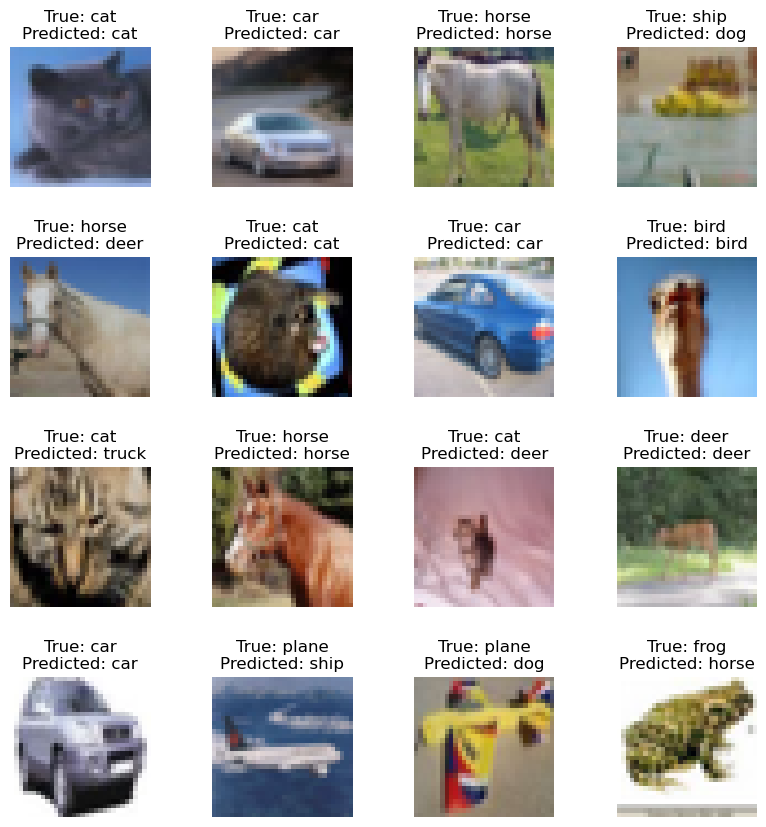

In [9]:
fig1 = plot_images(images=test_image, true_labels=test_labels, predicted_labels=label_pred_test, classes=dataset.classes)

## FixMatch

In [10]:
EPOCHS = 2

# Model
model = ConvNN().to(device)

# Criterion
supervised_criterion = nn.CrossEntropyLoss().to(device)
unsupervised_criterion = nn.CrossEntropyLoss().to(device)

# Metrics
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

# Optimizer & Scheduler
optimizer = torch.optim.AdamW(model.parameters())

/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/kornia/utils/helpers.py:123: UserWarning: torch.linalg_inv_ex.inverse is supported by MPS on MacOS 13+, please upgrade. Falling back to CPU. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/mps/operations/Inverse.mm:14.)
  return torch.inverse(input.to(dtype)).to(input.dtype)
/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/functional.py:4244: UserWarning: MPS: grid_sampler_2d op is supported natively starting from macOS 13.1. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/mps/operations/GridSampler.mm:139.)
  return torch.grid_sampler(input, grid, mode_enum, padding_mode_enum, align_corners)


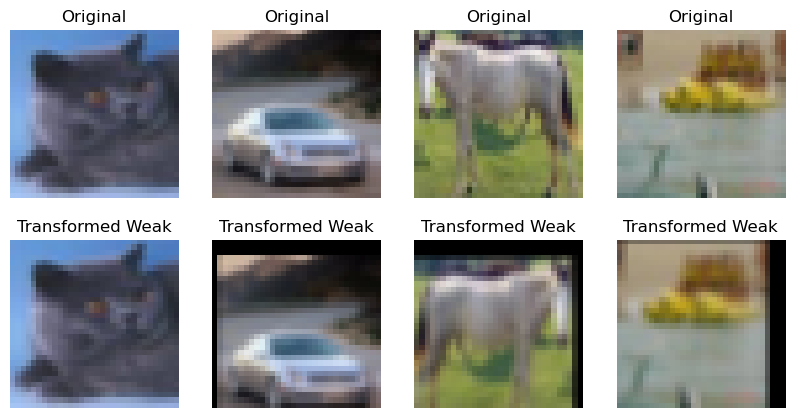

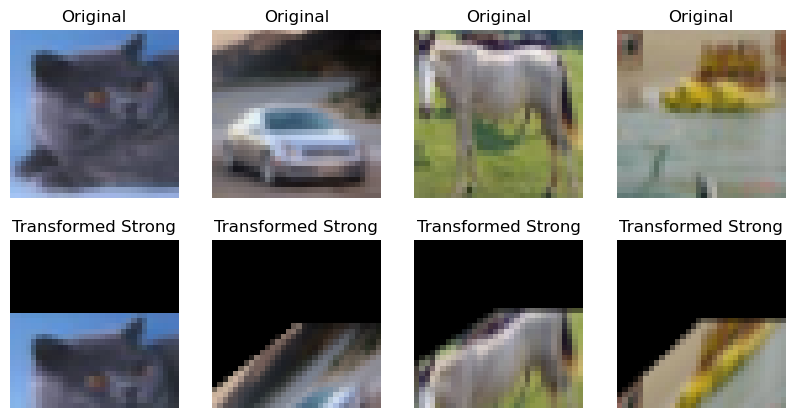

In [12]:
# Transform
weak_transform = K.ImageSequential(
    K.RandomHorizontalFlip(p=0.50), # 50% chance of flipping
    K.RandomAffine(degrees=0, translate=(0.125, 0.125)), # 12.5% chance of vertical of horizontal translation
)

strong_transform = K.ImageSequential(
    K.auto.AutoAugment("cifar10"),
    # K.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
)

fig2 = plot_transform(test_image, weak_transform, "Weak")
fig3 = plot_transform(test_image, strong_transform, "Strong")

In [18]:
dataset_fixmatch = DataFixMatch(data=dataset, batch_size=BATCH_SIZE, splits=[1/(1+MU), MU/(1+MU)])

trainloader_sup = dataset_fixmatch.get_trainsup_loader()
trainloader_unsup = dataset_fixmatch.get_trainunsup_loader()

In [19]:
# Training loop
for epoch in range(EPOCHS):
    # Training
    model.train()
    epoch_loss = 0.0
    trainloader_sup_iter = iter(trainloader_sup)

    for batch_idx in (pbar := tqdm(range(len(trainloader_sup)), desc=f"Epoch {epoch: >5}")):
        # extract mini batch
        images_sup, labels_sup = trainloader_sup_iter.__next__()
        images_sup, labels_sup = images_sup.to(device), labels_sup.to(device)
        
        # Supervised part
        with torch.no_grad():
            images_sup_weak = weak_transform(images_sup)
        logits_weak_pred_sup = model.forward(images_sup_weak)
        proba_weak_pred_sup = torch.nn.functional.softmax(logits_weak_pred_sup, dim=1)
        label_weak_pred_sup = proba_weak_pred_sup.argmax(dim=1)
        loss_weak_sup = supervised_criterion.forward(logits_weak_pred_sup, labels_sup)

        # Unsupervised part
        trainloader_unsup_iter = iter(trainloader_unsup)
        loss_strong_unsup = torch.tensor([0.0], device=device)
        for b_batch_idx in range(MU):
            images_unsup, _ = trainloader_unsup_iter.__next__()
            images_unsup = images_unsup.to(device)

            with torch.no_grad():
                image_unsup_weak = weak_transform(images_unsup)
            logits_weak_pred_unsup = model.forward(image_unsup_weak)
            proba_weak_pred_unsup = torch.nn.functional.softmax(logits_weak_pred_unsup, dim=1)
            label_weak_pred_unsup = proba_weak_pred_unsup.argmax(dim=1)
            confidence_mask = proba_weak_pred_unsup.max(dim=1)[0] > TAU

            if len(confidence_mask) != 0:
                continue

            image_unsup_strong = strong_transform(images_unsup)
            logits_strong_pred_unsup = model.forward(image_unsup_strong)
            proba_strong_pred_unsup = torch.nn.functional.softmax(logits_strong_pred_unsup, dim=1)
            label_strong_pred_unsup = proba_strong_pred_unsup.argmax(dim=1)

            if len(confidence_mask) != 0:
                loss_strong_unsup_ = unsupervised_criterion.forward(logits_strong_pred_unsup[confidence_mask], label_weak_pred_unsup[confidence_mask])#*(len(confidence_mask)/images_unsup.size(0))
                loss_strong_unsup  = loss_strong_unsup + loss_strong_unsup_
        # logits under the strong against the label under the weak for confident enough predictions

        # Total loss
        loss = loss_weak_sup + LAMBDA_U*loss_strong_unsup

Epoch     1: 100%|██████████| 88/88 [43:24<00:00, 29.60s/it]


In [20]:
test_image, test_labels = testLoader.__iter__().__next__()
test_image = test_image.to(device)
outputs_test = model(test_image)
label_pred_test = outputs_test.argmax(dim=1)

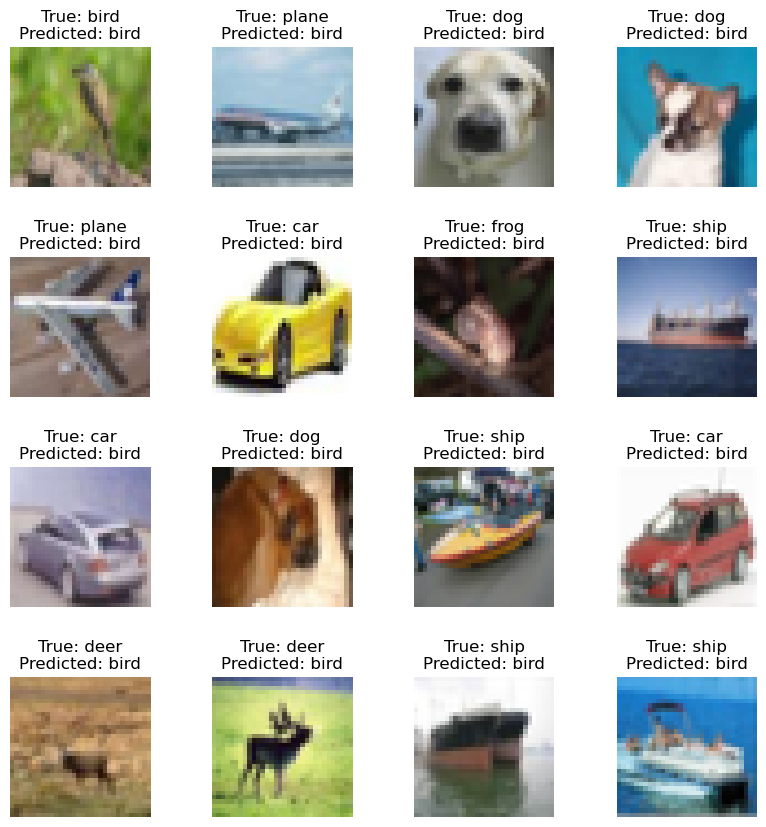

In [21]:
fig1 = plot_images(images=test_image, true_labels=test_labels, predicted_labels=label_pred_test, classes=dataset.classes)